In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# Make plots pretty
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid',
              palette='deep', font='sans-serif',
              font_scale=1, color_codes=True, rc=None)

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: TkAgg


# Pre-Lab 11

We designed our compensator to have a gain crossover frequency at $\frac{1}{8}$ the switching frequency, or $\omega_{gc} = 6.25kHz$. At this frequency, our plant has a gain of about $10dB \approx 3$, so we chose our overall gain to be $K_p = \frac{1}{3}$.

The phase margin of our plant (obtained in Lab 9) at the desired crossover frequency was very close to 90°, which would have left no phase margin once we added the integrator. Therefore, we relied on the lead element to generate the recommended phase margin of 60°---and what the heck, we went with 66°. I quite like this approach, as it gave us a large `K` value and a tall and wide phase boost. I do not see a downside to choosing an overly strong lead element, besides possibly the threat of overdamping.

We used the equations for the compensator components derived at the end of Lesson 13. The first time we calculated these values in class, we had an error of $2 \pi$ because we did not convert the crossover frequency from revolutions per second (Hertz) to radians per second for $\omega_c$. We re-calculated the values and used the highlighted row below.

In [10]:
def find_values(Rf1_unitless):
    Vout = 10 * units.volt
    Rf1 = Rf1_unitless * units.ohm
    Rf2 = Rf1 / 3 # 3 to 1 voltage divider produces 2.5V given a 10V input

    wc = 50 * units.kilohertz * units.revolutions / 8

    angle_boost = 66 * units.degree
    K = np.tan((angle_boost / 2 + 45 * units.degree))
    Kp = 1 / 3
    wz = wc / K
    wp = wc * K
    Gc0 = Kp * wc * np.sqrt((1 + K ** (-2)) / (1 + K ** 2))
    Cc1 = 1 / (Gc0 * Rf1)
    Rc1 = 1 / (wz * Cc1)
    Cc2 = 1 / (wp * Rc1)

    print(f"K: {K},\t Gc0: {Gc0.to_compact()},\t Rf1: {Rf1.to_compact(units.ohm)},\t Rf2: {Rf2.to_compact(units.ohm)},\t Rc1: {Rc1.to_compact(units.ohm)},\t Cc1: {Cc1.to_compact(units.farad)},  \t Cc2: {Cc2.to_compact(units.farad)}")

for R in [2, 2.2, 2.7, 3.3, 3.9, 4.3, 4.7, 5.1, 5.6, 6.2, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    if R == 7.5:
        print() # highlight the chosen value
    find_values(R * 1e3)
    if R == 7.5:
        print()

K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 2.00 kΩ,	 Rf2: 666.67 Ω,	 Rc1: 666.67 Ω,	 Cc1: 179.70 nF,  	 Cc2: 8.12 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 2.20 kΩ,	 Rf2: 733.33 Ω,	 Rc1: 733.33 Ω,	 Cc1: 163.37 nF,  	 Cc2: 7.38 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 2.70 kΩ,	 Rf2: 900.00 Ω,	 Rc1: 900.00 Ω,	 Cc1: 133.11 nF,  	 Cc2: 6.01 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 3.30 kΩ,	 Rf2: 1.10 kΩ,	 Rc1: 1.10 kΩ,	 Cc1: 108.91 nF,  	 Cc2: 4.92 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 3.90 kΩ,	 Rf2: 1.30 kΩ,	 Rc1: 1.30 kΩ,	 Cc1: 92.16 nF,  	 Cc2: 4.16 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 4.30 kΩ,	 Rf2: 1.43 kΩ,	 Rc1: 1.43 kΩ,	 Cc1: 83.58 nF,  	 Cc2: 3.78 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 4.70 kΩ,	 Rf2: 1.57 kΩ,	 Rc1: 1.57 kΩ,	 Cc1: 76.47 nF,  	 Cc2: 3.45 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 5.10 kΩ,	 Rf2: 1.70 kΩ,	 Rc1: 1.70 kΩ,	 Cc1: 70.47 nF,  	 Cc2: 3.18 nF
K: 4.70,	 Gc0: 442.83 Hz·turn,	 Rf1: 5.60 kΩ,	 Rf2: 1.87 kΩ,	 Rc1: 1.87 kΩ,	 Cc1: 64.18 nF,  	 Cc2: 2.90 nF
K: 4.70,	 Gc0: 442

# Lab 11
### Ian Eykamp

The components we used were `Rf1 = 7.50kOhm`, `Rf2 = 2.49kOhm`, `R5 = 2.49kOhm`, `C1 = 47nF`, and `C2 = 2.2nF`.

<img src="Zc_components.jpg" width="500" height="400">

The impedance value as a function of frequency (as well as much of the analysis) is analyzed similarly to in Lab 10. I will skip most of the derivations and focus on comparing the behavior of the new and old compensators.

Compared with the Lab 10 compensator, the current design has a lower cross-over frequency, larger K value, and larger phase boost due to the lead element. This is desirable, because it increases our phase margin significantly while not affecting the integrator component at low frequencies.

The expected output voltage given the voltage divider resistors is: 10.03 V
Lead element center voltage (ω_c): 6.29 kHz


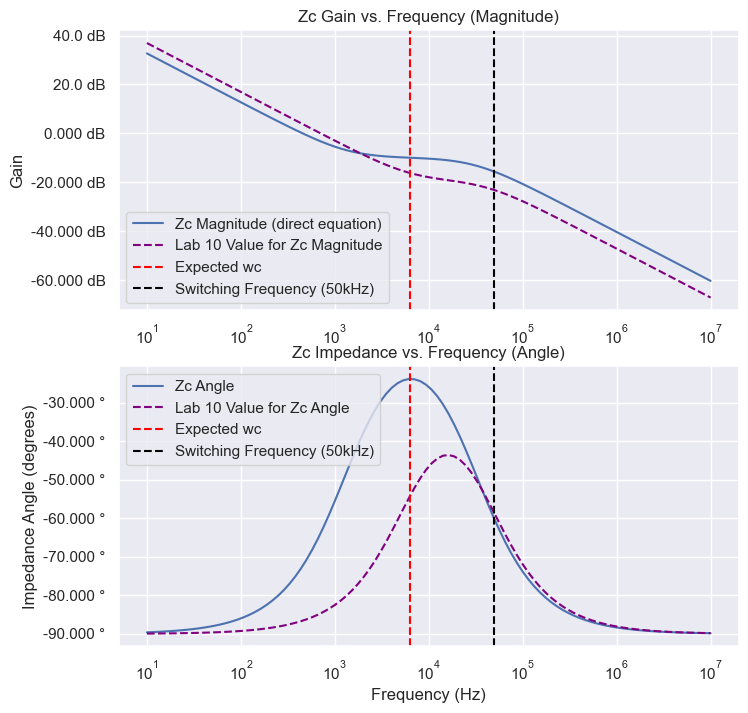

In [11]:
R2 = 7.5e3 # * units.kiloohm
R3 = 2.49e3 # * units.kiloohm
Vtarget = 2.5 * (R2 + R3) / R3 # * units.volt
print(f"The expected output voltage given the voltage divider resistors is: {si_format(Vtarget, precision = 2)}V")

C1 = 47e-9 # * units.nanofarad
C2 = 2.2e-9 # * units.nanofarad
R5 = 2.49e3 # * units.ohm
w = np.logspace(1, 7, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (R5 + 1 / (2 * np.pi * 1j * my_w * C1)) + 1 / (1 / (2 * np.pi * 1j * my_w * C2))) / 7.5e3 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation
def get_Zc_lab10(my_w_lab10):
    my_Zc_lab10 = (2 * np.pi * 1j * w / (40e3) + 1) / ((2 * np.pi * 1j * w / (1.9e7)) * (2 * np.pi * 1j * w / (250e3) + 1)) / 4.3e3 # kOhm # recreated equation
    return my_Zc_lab10
Zc_lab10 = get_Zc_lab10(w)

expected_wc = 1 / (R5 * np.sqrt(C1 * C2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", label = "Zc Magnitude (direct equation)")
ax1.semilogx(w, to_decibels(Zc_lab10), linestyle = "dashed", color = "purple", label = "Lab 10 Value for Zc Magnitude")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Impedance Angle (degrees)", "°", title = "Zc Impedance vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(w, np.angle(Zc_lab10, deg = True), linestyle = "dashed", color = "purple", label = "Lab 10 Value for Zc Angle")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")
# ax2.set_ylim(-100, -80)

## Bode Plots

<img src="whole_network.jpg" width="600" height="400">

In [12]:
# Import data
open_loop_bode = pd.read_csv("bode_plots/lab11-open.csv")
closed_loop_bode = pd.read_csv("bode_plots/lab11-closed.csv")
open_loop_lab10 = pd.read_csv("lab10_bode_plots/open-loop.csv")
closed_loop_lab10 = pd.read_csv("lab10_bode_plots/closed-loop.csv")
print(open_loop_bode.columns)

Index(['Frequency (Hz)', 'Channel 1 Magnitude (dB)',
       'Channel 2 Magnitude (dB)', 'Channel 2 Phase (deg)'],
      dtype='object')


### Open-Loop Transfer Function (GOL)

Open-loop gain cross-over frequency: 6.04 kHz
Open-loop gain cross-over phase margin: 68.84°
Open-loop phase cross-over frequency: 20.10 kHz
Open-loop phase cross-over gain margin: -9.99dB


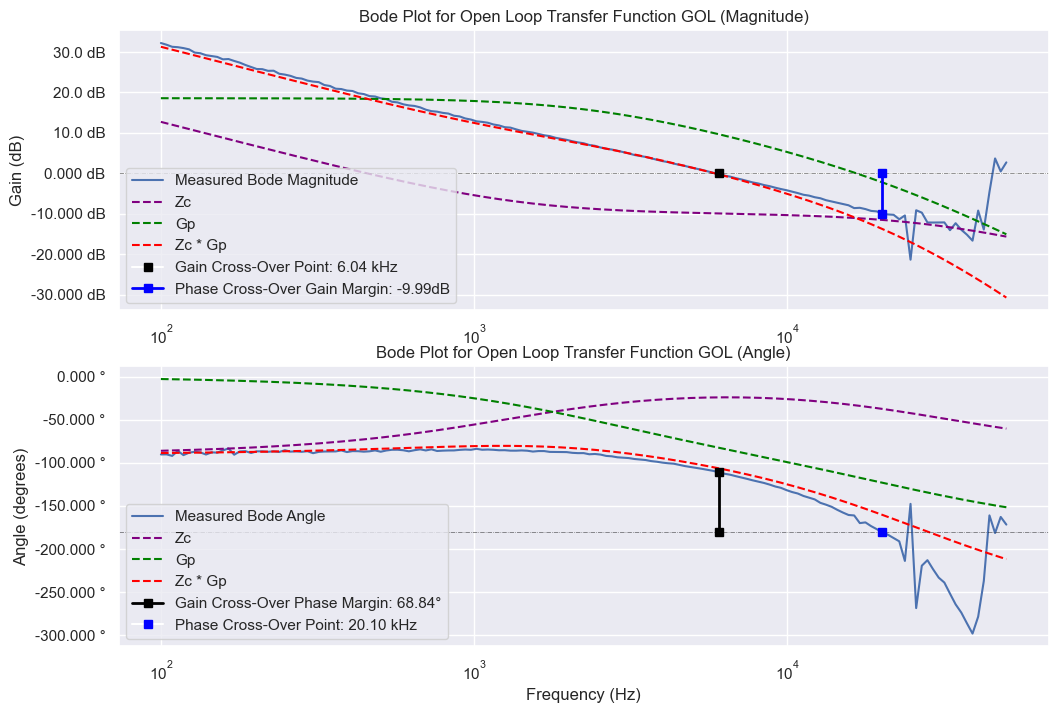

: 

In [17]:
w = open_loop_bode["Frequency (Hz)"]

Zc = get_Zc(w)
dc_gain = 18.58 # dB
G = 1 / ((w * 1j / 2.4e3) + 1) / ((w * 1j / 2.4e4) + 1) * 10**(dc_gain / 20) # optimized for 10V out

open_loop_gc = open_loop_bode[(open_loop_bode["Channel 2 Magnitude (dB)"] < 0) & (open_loop_bode["Frequency (Hz)"] < 2e4)].iloc[0]
open_loop_gc_freq = open_loop_gc["Frequency (Hz)"]
open_loop_gc_phase_margin = 180 - np.abs(open_loop_gc["Channel 2 Phase (deg)"])
print(f"Open-loop gain cross-over frequency: {si_format(open_loop_gc_freq, precision = 2)}Hz")
print(f"Open-loop gain cross-over phase margin: {np.round(open_loop_gc_phase_margin, 2)}°")

open_loop_pc = open_loop_bode[(open_loop_bode["Channel 2 Phase (deg)"] < -180)].iloc[0]
open_loop_pc_freq = open_loop_pc["Frequency (Hz)"]
open_loop_pc_gain_margin = open_loop_pc["Channel 2 Magnitude (dB)"]
print(f"Open-loop phase cross-over frequency: {si_format(open_loop_pc_freq, precision = 2)}Hz")
print(f"Open-loop phase cross-over gain margin: {np.round(open_loop_pc_gain_margin, 2)}dB")


fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (12, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Open Loop Transfer Function GOL (Magnitude)", ax = ax1)
ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
# ax1.semilogx(open_loop_lab10["Frequency (Hz)"], open_loop_lab10["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Lab 10 Bode Magnitude")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(Zc), linestyle = "dashed", color = "purple", label = "Zc")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G), linestyle = "dashed", color = "green", label = "Gp")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G * Zc), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax1.axhline(y = 0, color = "black", linestyle = "dashdot", linewidth = 0.5, alpha = 0.6)
ax1.semilogx(open_loop_gc_freq, 0, marker = 's', markersize = 6, markerfacecolor = "black", markeredgecolor = "black", color = "white", label = f"Gain Cross-Over Point: {si_format(open_loop_gc_freq, precision = 2)}Hz")
ax1.semilogx([open_loop_pc_freq, open_loop_pc_freq], [0, open_loop_pc_gain_margin], marker = 's', markersize = 6, markerfacecolor = "blue", markeredgecolor = "blue", color = "blue", linewidth = 2, label = f"Phase Cross-Over Gain Margin: {np.round(open_loop_pc_gain_margin, 2)}dB")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Open Loop Transfer Function GOL (Angle)", ax = ax2)
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(open_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
# ax2.semilogx(open_loop_lab10["Frequency (Hz)"], np.unwrap(open_loop_lab10["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Lab 10 Bode Angle")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(Zc, deg = True), period = 360), linestyle = "dashed", color = "purple", label = "Zc")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G, deg = True), period = 360), linestyle = "dashed", color = "green", label = "Gp")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G * Zc, deg = True), period = 360), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax2.axhline(y = -180, color = "black", linestyle = "dashdot", linewidth = 0.5, alpha = 0.6)
ax2.semilogx([open_loop_gc_freq, open_loop_gc_freq], [-180, -180 + open_loop_gc_phase_margin], marker = 's', markersize = 6, markerfacecolor = "black", markeredgecolor = "black", color = "black", linewidth = 2, label = f"Gain Cross-Over Phase Margin: {np.round(open_loop_gc_phase_margin, 2)}°")
ax2.semilogx(open_loop_pc_freq, -180, marker = 's', markersize = 6, markerfacecolor = "blue", markeredgecolor = "blue", color = "white", label = f"Phase Cross-Over Point: {si_format(open_loop_pc_freq, precision = 2)}Hz")
ax2.legend(loc = "lower left")

This bode plot was taken on the upstream (closer to Vout) side of the feedback loop *with reference to* the downstream (closer to VFB) side of the injected current. Thus, the *response* of the system in this configuration corresponds with the **open-loop** transfer function $G_{OL}$, since the feedback loop is **factored out**.

As in Lab 10, the open-loop transfer function matches well with the theoretical curve until slightly past the gain crossover frequency. After this point, the experimental gain is larger and the angle is more negative than the theoretical. The theotetical magnitude fit is improved by moving the second pole of $G_p(s)$ further to the right, and the theoretical angle fit is improved by moving the same pole to the left; the pole location is chosen to satisfy both curves as much as possible, but it matches neither perfectly. This points to an unmodeled feature of the plant or compensator transfer function at high frequencies. Fortunately, near the gain crossover frequency, the theoretical and experimental data match quite well, which means that our compensator calculations are mostly valid for the region we designed them for.

The transfer function using the previous compensator values (from Lab 10) is plotted in orange. The new transfer function has a higher gain crossover frequency and a much healthier phase margin (68° vs. 42°), mostly due to the larger lead element phase boost. The angle also remains close to 90° for a much wider range of frequencies. One disadvantage of the new compensator is that the phase-crossover phase margin is smaller than before (-10dB vs. -17dB), because the magnitude drops off much later (greater bandwidth).

### Closed-Loop Transfer Function (G)

Gain at cross-over frequency: 0.885 * exp(-0.97j)
That's -1.07 dB and -55.58 degrees
Damping ratio used: 0.7
Maximum gain of damped equation: 1.0


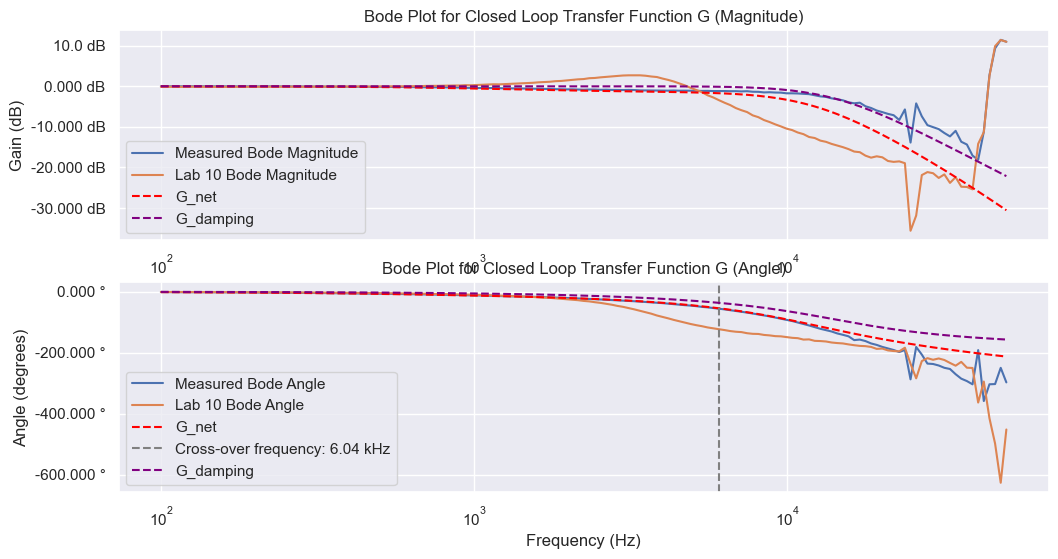

In [16]:
w = closed_loop_bode["Frequency (Hz)"]
G_new = G * Zc / (1 + G * Zc)

GOL_gc = np.exp(1j * np.deg2rad(-180 + open_loop_gc_phase_margin))
G_gc = GOL_gc / (1 + GOL_gc)
print(f"Gain at cross-over frequency: {np.round(np.abs(G_gc), 3)} * exp({np.round(np.angle(G_gc), 2)}j)")
print(f"That's {np.round(to_decibels(np.abs(G_gc)), 2)} dB and {np.round(np.angle(G_gc, deg = True), 2)} degrees")

# zeta = 0.7
zeta = 0.7
w_gc = 14e3 * 2 * np.pi # open_loop_gc_freq * 2 * np.pi
G_damping = w_gc ** 2 / ((2 * np.pi * 1j * w) ** 2 + 2 * zeta * w_gc * 2 * np.pi * 1j * w + w_gc ** 2)
print(f"Damping ratio used: {zeta}")
print(f"Maximum gain of damped equation: {np.round(max(np.abs(G_damping)), 3)}")

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Closed Loop Transfer Function G (Magnitude)", ax = ax1)
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], closed_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
ax1.semilogx(closed_loop_lab10["Frequency (Hz)"], closed_loop_lab10["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Lab 10 Bode Magnitude")
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], to_decibels(G_new), linestyle = "dashed", color = "red", label = "G_net")
ax1.semilogx(w, to_decibels(G_damping), linestyle = "dashed", color = "purple", label = "G_damping")
# ax1.axhline(y = to_decibels(np.abs(G_gc)), linestyle = "dashed", color = "black", label = f"Gain at cross-over frequency: {np.round(to_decibels(np.abs(G_gc)), 2)}dB")
# ax1.axvline(x = open_loop_gc_freq, linestyle = "dashed", color = "grey", label = f"Cross-over frequency: {si_format(open_loop_gc_freq, precision = 2)}Hz")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Closed Loop Transfer Function G (Angle)", ax = ax2)
ax2.semilogx(closed_loop_bode["Frequency (Hz)"], np.unwrap(closed_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.semilogx(closed_loop_lab10["Frequency (Hz)"], np.unwrap(closed_loop_lab10["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Lab 10 Bode Angle")
ax2.semilogx(closed_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G_new, deg = True), period = 360), linestyle = "dashed", color = "red", label = "G_net")
ax2.axvline(x = open_loop_gc_freq, linestyle = "dashed", color = "grey", label = f"Cross-over frequency: {si_format(open_loop_gc_freq, precision = 2)}Hz")
ax2.semilogx(w, np.unwrap(np.angle(G_damping, deg = True), period = 360), linestyle = "dashed", color = "purple", label = "G_damping")
# ax2.axhline(y = -90, linestyle = "dashed", color = "black")
ax2.legend(loc = "lower left")

This bode plot was taken on the upstream (closer to Vout) side of the feedback loop with reference to the *source* of the perturbation. The feedback loop is left intact and not accounted for separately, so this bode plot represents the response of the **closed-loop system** to a perterbation on the feedback line corresponding to a change in Vout.

The transfer function for a system with a damped second-order pole is given by $G(s) = \frac{{\omega_{0}}^2}{s^2 + 2 \zeta \omega_{0} s + {\omega_{0}}^2}$, where $\omega_0$ is the location of the pole. I asssumed that the pole would be located at the gain crossover frequency $\omega_0 = \omega_{gc}$, but this produces a curve that is shifted too far to the left. I adjusted $\omega_0$ and $\zeta$ until it matched the experimental data. The best fit was achieved with $\omega_0 = 14kHz$ and $\zeta = 0.7$, although this method is not very sensitive to $\zeta$. Again, the fit for the magnitude is better achieved when $\omega_0$ is further to the right, whereas the fit for the angle is better when $\omega_0$ is further to the left. I do not know how to explain this behavior.

The new compensator produces much better damping than the old design. The new compensator has a much higher bandwidth (higher even than expected based on $G_p$ and $Z_c$). This might mean that the system is slightly less stable, because there is less attenuation of signals near the switching frequency. This also leads to the smaller phase-crossover gain margin observed earlier.

Output swing: 831.95 mV for a 1V perturbation
That's a gain of 0.83
It overshoots by 50.00 mV and undershoots by 40.00 mV
Zeta from overshoot: 0.67
Zeta from earlier (for comparison): 0.7


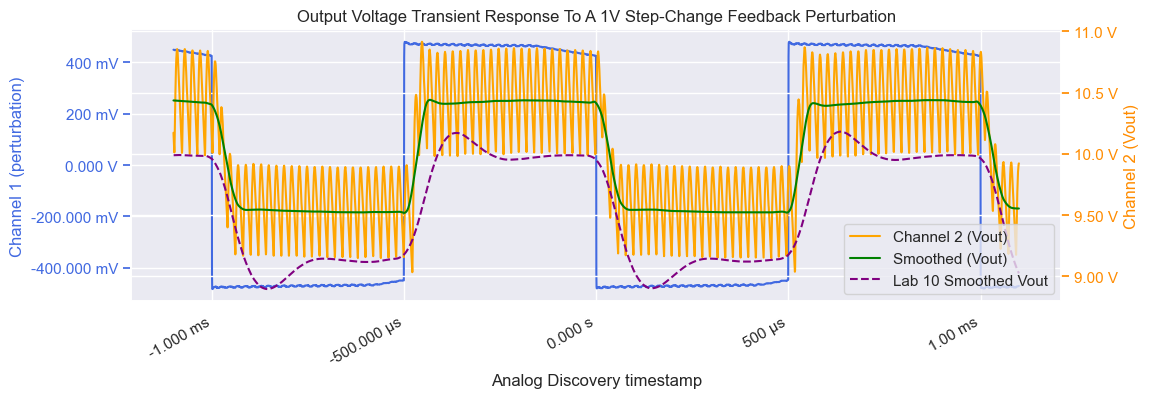

In [15]:
df_step_response = pd.read_csv("bode_plots/lab11-step.csv")
lab10_step_response = pd.read_csv("lab10_bode_plots/lab10_step_response_trace.csv")

# print(df_step_response.head(5))

def moving_average(x, w):
    w = int(w / 2) * 2
    convolution = np.convolve(x, np.ones(w), 'full') / w
    return convolution[int(w/2):-int(w/2)+1]
    
df_step_response["Channel 1 (V)"] = -df_step_response["Channel 1 (V)"]
df_step_response["Channel 2 (V)"] = -df_step_response["Channel 2 (V)"]
# df_step_response["Ch2_moving_average"] = moving_average(df_step_response["Channel 2 (V)"], 200) # old method with still some ripple

peak_idx = find_peaks(df_step_response["Channel 2 (V)"])[0]
trough_idx = find_peaks(-df_step_response["Channel 2 (V)"])[0]
df_peak_trace = df_step_response.copy().iloc[np.sort(np.concatenate((peak_idx, trough_idx)))]
df_peak_trace["peak_moving_average"] = np.convolve(df_peak_trace["Channel 2 (V)"], [1, 1], 'same') / 2
df_step_response["Ch2_moving_average"] = moving_average(np.interp(df_step_response["Time (s)"], df_peak_trace["Time (s)"], df_peak_trace["peak_moving_average"]), 100)

df_zoom = df_step_response[(df_step_response["Time (s)"] > -1.1e-3) & (df_step_response["Time (s)"] < 1.1e-3)]
lab10_zoom = lab10_step_response[(lab10_step_response["Time (s)"] > -1.1e-3) & (lab10_step_response["Time (s)"] < 1.1e-3)]
# df_peak_trace_zoom = df_peak_trace_2[(df_peak_trace_2["Time (s)"] > -1.1e-3) & (df_peak_trace_2["Time (s)"] < 1.1e-3)]

overshoot = np.max(df_zoom["Ch2_moving_average"]) # 10.6 # V
top_steady_state = overshoot - 0.05 # = 10 # V
undershoot = np.min(df_zoom["Ch2_moving_average"]) # 8.5 # V
bottom_steady_state = undershoot + 0.04 # = 9.13 # V
output_swing = top_steady_state - bottom_steady_state

overshoot_ratio = (overshoot - top_steady_state) / output_swing
zeta_from_overshoot = np.sqrt(np.log(overshoot_ratio) ** 2 / (np.pi ** 2 + np.log(overshoot_ratio) ** 2))
print(f"Output swing: {si_format(output_swing, precision = 2)}V for a 1V perturbation")
print(f"That's a gain of {np.round(output_swing / 1.0, 2)}")
print(f"It overshoots by {si_format(overshoot - top_steady_state, precision = 2)}V and undershoots by {si_format(bottom_steady_state - undershoot, precision = 2)}V")
print(f"Zeta from overshoot: {np.round(zeta_from_overshoot, 2)}")
print(f"Zeta from earlier (for comparison): {np.round(zeta, 2)}")

fig, (ax1_left) = plt.subplots(nrows = 1, ncols = 1, sharex = False, sharey = True, figsize = (12, 4))
ax1_right = ax1_left.twinx()
fig.autofmt_xdate()
helper.axes_labels("Analog Discovery timestamp", "s", "Channel 1 (perturbation)", "V", title = "", ax = ax1_left)
helper.axes_labels("Analog Discovery timestamp", "s", "Channel 2 (Vout)", "V", title = "Output Voltage Transient Response To A 1V Step-Change Feedback Perturbation", ax = ax1_right)
ax1_left.plot(df_zoom["Time (s)"], df_zoom["Channel 1 (V)"], color = "royalblue", label = "Channel 1 (perturbation)")
ax1_right.plot(df_zoom["Time (s)"], df_zoom["Channel 2 (V)"], color = "orange", label = "Channel 2 (Vout)")
ax1_right.plot(df_zoom["Time (s)"], df_zoom["Ch2_moving_average"], color = "green", label = "Smoothed (Vout)")
ax1_right.plot(lab10_zoom["Time (s)"], lab10_zoom["Ch2_moving_average"], color = "purple", linestyle = "dashed", label = "Lab 10 Smoothed Vout")
# ax1_right.axhline(y = overshoot, linestyle = "dashed", color = "black", label = "overshoot")
# ax1_right.axhline(y = top_steady_state, linestyle = "dashed", color = "black", label = "top_steady_state")
# ax1_right.axhline(y = bottom_steady_state, linestyle = "dashed", color = "black", label = "bottom_steady_state")
# ax1_right.axhline(y = undershoot, linestyle = "dashed", color = "black", label = "undershoot")
ax1_left.yaxis.label.set_color('royalblue')
ax1_left.tick_params(axis='y', colors='royalblue')
ax1_right.tick_params(axis='y', colors='darkorange')
ax1_right.yaxis.label.set_color('darkorange')
ax1_right.legend(loc = "lower right")

A 1V square-wave perturbation was applied to the feedback loop. The output voltage had time to settle between each cycle, so the response can be analyzed like a step response. The output voltage ripple (orange) is inherent to the power converter, so what we care about is the DC output voltage response (green). The output voltage is centered around 10.07V and swings by around 830mV in response to the 1V feedback perturbation. In my Lab 10 report, I mistakenly thought the perturbation was a 100mV step change, not 1V. I reported that there was a large gain between the perturbation and the output response, when in reality, there is slightly less than unity gain.

According to [this resource](https://www.et.byu.edu/~tom/classes/436/ClassNotes/Class20(Second-Order).pdf#page=4), the damping ratio $\zeta$ can be obtained from the overshoot ratio $O = \frac{\text{overshoot}}{\text{output swing}}$ by the equation $\zeta = \sqrt{(\frac{ln^2(O)}{\pi^2 + ln^2(O)})}$. Plugging in the values for overshoot and output swing yields a damping ratio of $\zeta = 0.67$. This is very similar to the damping ratio of 0.7 found earlier.

Compared with the previous compensator, the new design yields an output voltage much closer to 10.0V (10.00V-10.07V vs. 9.60V), improved phase margin (68° vs. 42°), and greater damping ratio (0.67 vs. 0.45) which nearly eliminates the overshoot while still converging quickly. In conclusion, I believe that our compensator comonent values are very close to ideal.